In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import glob
import os
import pandas as pd
import numpy as np
import torch.nn as nn


image_folder = r"C:\Users\ssmee\Google Drive\Sameer's Files\Academic\Misc\SVD\face_archive\real_and_fake_face\training_real"
image_ext = '.jpg'
images = glob.glob(os.path.join(image_folder, f'*{image_ext}'))
print(f'{len(images)} images found')
image_ids = [os.path.basename(image).removesuffix(image_ext) for image in images]
df_images = pd.DataFrame({'fullpath':images}, index = image_ids)
df_images['target'] = np.random.rand(len(df_images))
print(df_images)



1098 images found
                                                     fullpath    target
0Curt       C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.786582
0Devon      C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.269055
0Niko       C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.567520
0Ray        C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.626473
1           C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.699872
...                                                       ...       ...
real_01077  C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.645969
real_01078  C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.369851
real_01079  C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.744455
real_01080  C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.389938
real_01081  C:\Users\ssmee\Google Drive\Sameer's Files\Aca...  0.306325

[1098 rows x 2 columns]


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, df_images, transform=None, target_transform=None):
        self.df_images = df_images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        img_path = self.df_images.loc[self.df_images.index[idx], 'fullpath']
        image = read_image(img_path)
        

        target = self.df_images.loc[self.df_images.index[idx], 'target']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target


training_data = CustomImageDataset(df_images)
test_data = CustomImageDataset(df_images)


train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 600, 600])
Labels batch shape: torch.Size([64])


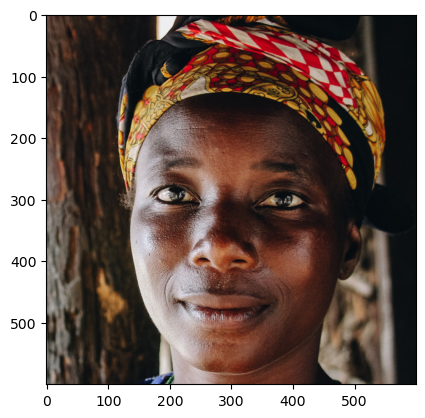

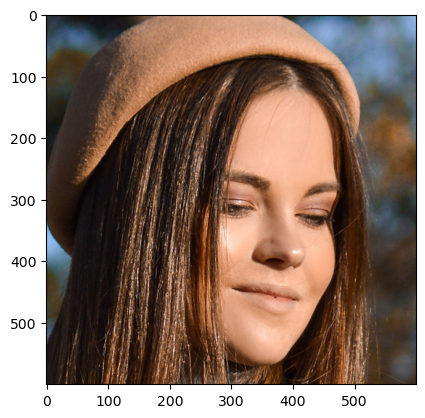

In [3]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

for i in range(2):
    img = train_features[i].squeeze().permute((1, 2, 0))
    plt.imshow(img, cmap="gray")
    plt.show()


In [4]:
class CNNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
   
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = torch.amax(x, dim=(1, 2, 3))

        return x
 
model = CNNmodel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for i in range(100):
    x_train, y_actual_train = next(iter(train_dataloader))

    y_pred = model(x_train.clone().float()/256)

    loss = loss_fn(y_pred, y_actual_train.float())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

    #print(y_pred)

tensor(0.2748, grad_fn=<MseLossBackward0>)
tensor(0.2929, grad_fn=<MseLossBackward0>)
